# PixNerd text-to-image checkpoint inference (T2I)

This notebook loads a PixNerd XL text-to-image checkpoint, runs prompt-based sampling, and visualizes both the training resolution and higher-resolution outputs from within the notebook.


## Environment & paths
- Requires a GPU runtime (the Qwen3 text encoder forces CUDA and bfloat16).
- Assumes dependencies from `requirements.txt` are installed.
- Place the checkpoint at `checkpoints/PixNerd-XL-P16-C2I/model.ckpt` relative to the repo root (adjust the path if yours differs).
- Set `TEXT_ENCODER_PATH` to a local or cached copy of `Qwen/Qwen3-1.7B` if your environment lacks internet.


In [1]:
cd ..

/pscratch/sd/k/kevinval/PixNerd


/pscratch/sd/k/kevinval/envs/pixnerd/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
from pathlib import Path
import math
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Optional: change to your repo root if running from elsewhere
REPO_ROOT = Path(os.getcwd())
print(REPO_ROOT)

# Checkpoint location (adjust if yours lives elsewhere)
CKPT_PATH = REPO_ROOT / "checkpoints/checkpoints/PixNerd-XXL-P16-T2I/model.ckpt"

# Text encoder weights (Hugging Face model name or local path)
TEXT_ENCODER_PATH = "/pscratch/sd/k/kevinval/models/Qwen3-1.7B"

# Where to save generated images
OUTPUT_DIR = REPO_ROOT / "notebooks" / "pixnerd_t2i_inference_outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE != "cuda":
    raise RuntimeError("PixNerd T2I inference requires a CUDA GPU (Qwen3TextEncoder uses .cuda())")

print(f"Repo root: {REPO_ROOT}")
print(f"Checkpoint exists: {CKPT_PATH.exists()}")
print(f"Using device: {DEVICE}")


/pscratch/sd/k/kevinval/PixNerd
Repo root: /pscratch/sd/k/kevinval/PixNerd
Checkpoint exists: True
Using device: cuda


## Build the PixNerd XL T2I model components
This mirrors the text-to-image configuration:
- Pixel-space autoencoder (`PixelAE`)
- Qwen3 text conditioner
- PixNerDiT heavy decoder (patch size 16, hidden dim 1536)
- Adam LM sampler with classifier-free guidance
- REPATrainer stub (only so projection weights load from the checkpoint)


In [3]:
from src.models.autoencoder.pixel import PixelAE
from src.models.conditioner.qwen3_text_encoder import Qwen3TextEncoder
from src.models.transformer.pixnerd_t2i_heavydecoder import PixNerDiT
from src.diffusion.flow_matching.scheduling import LinearScheduler
from src.diffusion.flow_matching.adam_sampling import AdamLMSampler, ode_step_fn
from src.diffusion.base.guidance import simple_guidance_fn
from src.diffusion.flow_matching.training_repa import REPATrainer
from src.callbacks.simple_ema import SimpleEMA
from src.lightning_model import LightningModel
from src.models.encoder import IndentityMapping
from src.models.autoencoder.base import fp2uint8

# Model hyperparameters (from configs_t2i/inference_heavydecoder.yaml)
HIDDEN_SIZE = 1536
TXT_EMBED_DIM = 2048
PATCH_SIZE = 16

# Scheduler
main_scheduler = LinearScheduler()

# Core modules
vae = PixelAE(scale=1.0)
conditioner = Qwen3TextEncoder(weight_path=TEXT_ENCODER_PATH, embed_dim=TXT_EMBED_DIM, max_length=128)
denoiser = PixNerDiT(
    in_channels=3,
    patch_size=PATCH_SIZE,
    num_groups=24,
    hidden_size=HIDDEN_SIZE,
    txt_embed_dim=TXT_EMBED_DIM,
    txt_max_length=128,
    num_text_blocks=4,
    decoder_hidden_size=64,
    num_encoder_blocks=16,
    num_decoder_blocks=2,
)

# Sampler mirrors the text-to-image setup
sampler = AdamLMSampler(
    num_steps=25,
    guidance=4.0,
    timeshift=3.0,
    order=2,
    scheduler=main_scheduler,
    guidance_fn=simple_guidance_fn,
    step_fn=ode_step_fn,
)

# REPATrainer is only instantiated so its projection MLP weights can be loaded from the checkpoint
trainer_stub = REPATrainer(
    scheduler=main_scheduler,
    lognorm_t=True,
    timeshift=4.0,
    feat_loss_weight=0.5,
    encoder=IndentityMapping(),  # placeholder; encoder is unused for inference
    align_layer=6,
    proj_denoiser_dim=HIDDEN_SIZE,
    proj_hidden_dim=HIDDEN_SIZE,
    proj_encoder_dim=768,
)

ema_tracker = SimpleEMA(decay=0.9999)

# Wrap everything in the LightningModel for easy checkpoint loading
model = LightningModel(
    vae=vae,
    conditioner=conditioner,
    denoiser=denoiser,
    diffusion_trainer=trainer_stub,
    diffusion_sampler=sampler,
    ema_tracker=ema_tracker,
    optimizer=None,
    lr_scheduler=None,
    eval_original_model=False,
)
model.eval()
model.to(DEVICE)
print("Model initialized.")


/pscratch/sd/k/kevinval/envs/pixnerd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Model initialized.


## Load the checkpoint (EMA weights)
`strict=False` lets us ignore any optimizer or trainer state that may be absent. EMA weights are stored under `ema_denoiser.*` and are used for sampling.


In [4]:
ckpt = torch.load(CKPT_PATH, map_location="cpu")
missing, unexpected = model.load_state_dict(ckpt["state_dict"], strict=False)
print(f"Missing keys: {len(missing)} | Unexpected keys: {len(unexpected)}")
print("Ready for text-to-image sampling with EMA denoiser.")


/tmp/ipykernel_421504/1661140885.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location="cpu")


Missing keys: 310 | Unexpected keys: 0
Ready for text-to-image sampling with EMA denoiser.


## Sampling helpers
- `sample_prompts` draws Gaussian noise, runs the Adam LM sampler with classifier-free guidance, decodes to pixel space, and returns uint8 tensors.
- `save_grid` writes a simple grid PNG for quick inspection.


In [10]:
@torch.no_grad()
def sample_prompts(prompts, height=512, width=512, seed=0, guidance=4.0, num_steps=25):
    torch.manual_seed(seed)
    batch = len(prompts)

    # Update guidance or steps on the fly if desired
    model.diffusion_sampler.guidance = guidance
    model.diffusion_sampler.num_steps = num_steps

    noise = torch.randn(batch, 3, height, width, device=DEVICE)

    condition, uncondition = model.conditioner(prompts)
    samples = model.diffusion_sampler(
        model.ema_denoiser,
        noise,
        condition,
        uncondition,
    )
    images = model.vae.decode(samples)
    images = torch.clamp(images, -1.0, 1.0)
    images_uint8 = fp2uint8(images)
    return images_uint8.cpu()


def save_grid(images_uint8, filename, cols=None):
    # images_uint8: [B, 3, H, W] or numpy with same layout
    if isinstance(images_uint8, torch.Tensor):
        imgs_np = images_uint8.permute(0, 2, 3, 1).cpu().numpy()  # -> [B, H, W, 3]
    else:
        # assume numpy [B, 3, H, W]
        imgs_np = np.transpose(images_uint8, (0, 2, 3, 1))

    imgs = [Image.fromarray(img) for img in imgs_np]

    n = len(imgs)
    if cols is None:
        cols = math.ceil(math.sqrt(n))
    rows = math.ceil(n / cols)

    w, h = imgs[0].size
    grid = Image.new("RGB", (cols * w, rows * h))
    for idx, img in enumerate(imgs):
        r, c = divmod(idx, cols)
        grid.paste(img, (c * w, r * h))

    out_path = OUTPUT_DIR / filename
    grid.save(out_path)
    return out_path



## Generate 512×512 samples from prompts
Edit `PROMPTS` to whatever you like. Adjust `SEED`, `GUIDANCE`, or `NUM_STEPS` as needed.


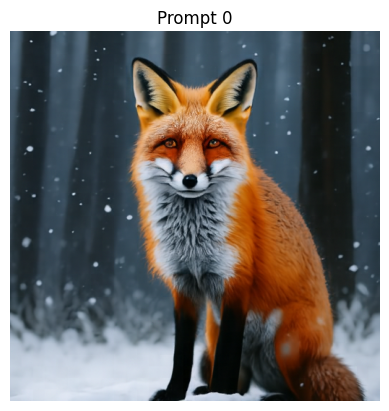

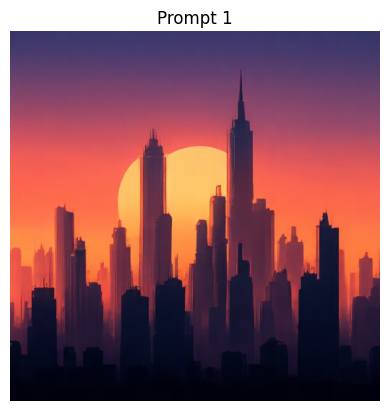

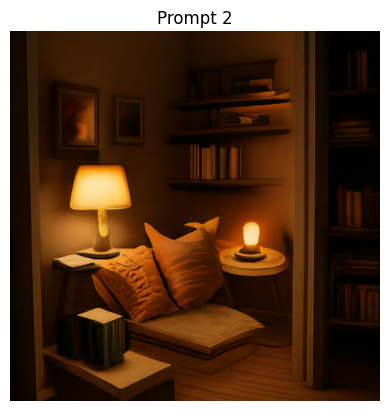

PosixPath('/pscratch/sd/k/kevinval/PixNerd/notebooks/pixnerd_t2i_inference_outputs/pixnerd_t2i_512_grid.png')

In [11]:
PROMPTS = [
    "a photo of a red fox in a snowy forest",
    "a futuristic city skyline at sunset, digital art",
    "a cozy reading nook with warm lighting",
]
SEED = 123
GUIDANCE = 4.0
NUM_STEPS = 25

images_512 = sample_prompts(
    prompts=PROMPTS,
    height=512,
    width=512,
    seed=SEED,
    guidance=GUIDANCE,
    num_steps=NUM_STEPS,
)

import numpy as np

for i, img in enumerate(images_512):
    # img is [3, H, W] (C, H, W) -> convert to [H, W, C]
    if isinstance(img, torch.Tensor):
        img_vis = img.permute(1, 2, 0).cpu().numpy()
    else:  # numpy array already
        # assume it's C,H,W as well
        img_vis = np.transpose(img, (1, 2, 0))

    plt.figure()
    plt.imshow(img_vis)
    plt.axis('off')
    plt.title(f"Prompt {i}")
plt.show()


save_grid(images_512, "pixnerd_t2i_512_grid.png")


## Super-resolution sampling (e.g., 768×768 or 1024×1024)
Because the model works in pixel space with coordinate-aware embeddings, simply draw higher-resolution noise and run the same sampler. You can tweak guidance/steps for the higher resolution if needed.


=== 512x512 native ===
512 shape: torch.Size([3, 3, 512, 512]) torch.uint8


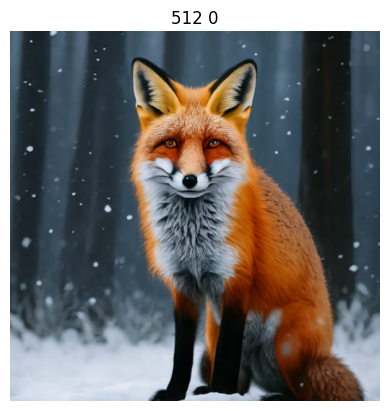

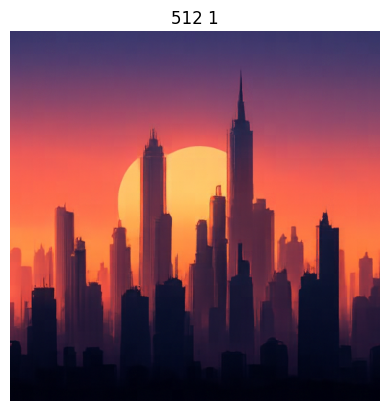

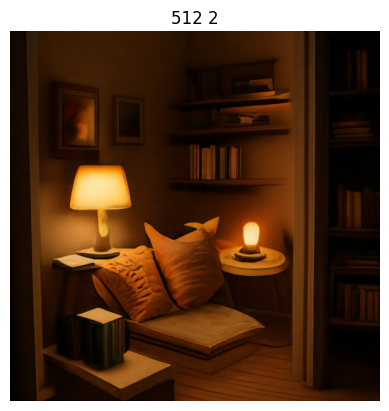


=== 1920x1920 NF super-res ===
SR shape: torch.Size([3, 3, 1920, 1920]) torch.uint8


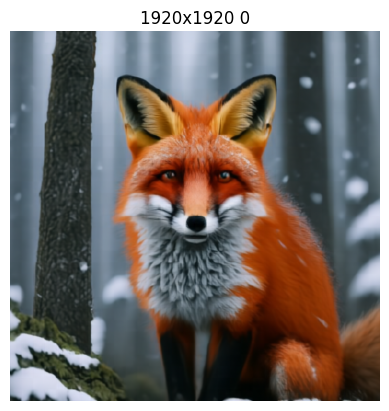

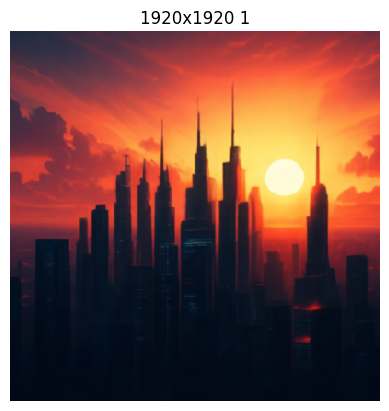

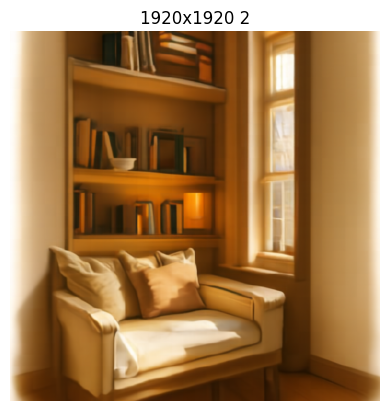

PosixPath('/pscratch/sd/k/kevinval/PixNerd/notebooks/pixnerd_t2i_inference_outputs/pixnerd_t2i_1920sq_grid.png')

In [18]:
import math, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

BASE_RES = 512  # training resolution of the T2I heavydecoder checkpoint

# --- helper: set decoder scaling on both denoisers ---
def set_decoder_scale(scale: float):
    for net in [model.denoiser, getattr(model, "ema_denoiser", None)]:
        if net is None:
            continue
        net.decoder_patch_scaling_h = scale
        net.decoder_patch_scaling_w = scale

@torch.no_grad()
def sample_prompts(
    prompts,
    height=512,
    width=512,
    seed=0,
    guidance=4.0,
    num_steps=25,
    base_res=BASE_RES,
):
    """
    - If height == width == base_res: native 512 generation (no scaling)
    - If height/width differ: keep encoder at base_res, scale NF decoder patches
      by (height/base_res).
    """
    assert height == width, "only square images supported in this helper"

    torch.manual_seed(seed)
    batch = len(prompts)

    # diffusion hyperparams
    model.diffusion_sampler.guidance = guidance
    model.diffusion_sampler.num_steps = num_steps

    # --- set NF super-res scale ---
    if height == base_res:
        # native 512: no scaling
        set_decoder_scale(1.0)
    else:
        scale = height / float(base_res)
        set_decoder_scale(scale)

    # noise at target resolution
    noise = torch.randn(batch, 3, height, width, device=DEVICE)

    # text condition / uncondition
    condition, uncondition = model.conditioner(prompts)

    # sample with EMA denoiser
    samples = model.diffusion_sampler(
        model.ema_denoiser,
        noise,
        condition,
        uncondition,
    )
    images = model.vae.decode(samples)          # [-1,1] in [B,3,H,W]
    images = torch.clamp(images, -1.0, 1.0)
    images_uint8 = fp2uint8(images)             # [B,3,H,W] uint8
    return images_uint8.cpu()                   # CHW per image


def save_grid(images_uint8, filename, cols=None):
    # images_uint8: [B,3,H,W] tensor or numpy
    if isinstance(images_uint8, torch.Tensor):
        imgs_np = images_uint8.permute(0, 2, 3, 1).cpu().numpy()  # [B,H,W,3]
    else:
        # assume numpy [B,3,H,W]
        imgs_np = np.transpose(images_uint8, (0, 2, 3, 1))

    imgs = [Image.fromarray(img) for img in imgs_np]

    n = len(imgs)
    if cols is None:
        cols = n
    rows = math.ceil(n / cols)

    w, h = imgs[0].size
    grid = Image.new("RGB", (cols * w, rows * h))
    for idx, img in enumerate(imgs):
        r, c = divmod(idx, cols)
        grid.paste(img, (c * w, r * h))

    out_path = OUTPUT_DIR / filename
    grid.save(out_path)
    return out_path


def show_batch(images_uint8, title_prefix=""):
    # images_uint8: [B,3,H,W]
    if isinstance(images_uint8, torch.Tensor):
        imgs_np = images_uint8.permute(0, 2, 3, 1).cpu().numpy()
    else:
        imgs_np = np.transpose(images_uint8, (0, 2, 3, 1))

    for i, img in enumerate(imgs_np):
        plt.figure()
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title_prefix} {i}")
    plt.show()



PROMPTS = [
    "a photo of a red fox in a snowy forest",
    "a futuristic city skyline at sunset, digital art",
    "a cozy reading nook with warm lighting",
]

SEED = 123
GUIDANCE = 4.0
NUM_STEPS = 25

# --- 512x512 native (no NF scaling) ---
print("=== 512x512 native ===")
images_512 = sample_prompts(
    prompts=PROMPTS,
    height=512,
    width=512,
    seed=SEED,
    guidance=GUIDANCE,
    num_steps=NUM_STEPS,
    base_res=BASE_RES,
)
print("512 shape:", images_512.shape, images_512.dtype)
show_batch(images_512, title_prefix="512")

save_grid(images_512, "pixnerd_t2i_512_grid.png", cols=len(PROMPTS))


# --- 768x768 super-res (NF scaling) ---
HIGH_RES = 1920
SUPERRES_SEED = 123
SUPERRES_GUIDANCE = 4.0
SUPERRES_STEPS = 25

print(f"\n=== {HIGH_RES}x{HIGH_RES} NF super-res ===")
images_sr = sample_prompts(
    prompts=PROMPTS,
    height=HIGH_RES,
    width=HIGH_RES,
    seed=SUPERRES_SEED,
    guidance=SUPERRES_GUIDANCE,
    num_steps=SUPERRES_STEPS,
    base_res=BASE_RES,   # keep encoder grid at 512
)
print("SR shape:", images_sr.shape, images_sr.dtype)
show_batch(images_sr, title_prefix=f"{HIGH_RES}x{HIGH_RES}")

save_grid(images_sr, f"pixnerd_t2i_{HIGH_RES}sq_grid.png", cols=len(PROMPTS))
